## 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
from time import time
from MomentLearn import utils
from MomentLearn import model as model_utils
from MomentLearn.model import Net
import prody as pd
import matplotlib.pyplot as plt
from caretta.score_functions import get_caretta_score
from caretta.multiple_alignment import tm_score
from caretta import superposition_functions, helper, multiple_alignment

In [2]:
X_names, mapk_pdb_id_to_class = utils.get_example_metadata()
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
mapping = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

In [3]:
start_time = time()
pdbs = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

@> PDB file is found in working directory (3o2m.pdb).
@> 2935 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3o2m.pdb).
@> 2935 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh8.pdb.gz).
@> 2778 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh2.pdb).
@> 2842 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh7.pdb.gz).
@> 2788 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh5.pdb.gz).
@> 2783 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4dli.pdb.gz).
@> 2861 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh3.pdb.gz).
@> 2784 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4eh6.pdb.gz).
@> 2825 atoms an

50 proteins fetched in 1.59 seconds


@> 2708 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (6rq4.pdb.gz).
@> 3110 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6slg.pdb.gz).
@> 2871 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6ohd.pdb.gz).
@> 2759 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6sfi.pdb.gz).
@> 3127 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6sfk.pdb.gz).
@> 2995 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6sfo.pdb.gz).
@> 2905 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6oph.pdb.gz).
@> 2902 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (6opg.pdb.gz).
@> 3050 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> P

100 proteins fetched in 3.35 seconds


@> 2837 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (5xyx.pdb.gz).
@> 2749 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (6f5e.pdb.gz).
@> 5645 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> PDB file is found in working directory (5lw1.pdb.gz).
@> 2912 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> PDB file is found in working directory (5lw1.pdb.gz).
@> 2912 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> PDB file is found in working directory (5lw1.pdb.gz).
@> 2917 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> PDB file is found in working directory (1cm8.pdb.gz).
@> 2739 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (5mtx.pdb.gz).
@> 2867 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (1pmv.pdb.gz).
@> 2899 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> P

150 proteins fetched in 5.37 seconds


@> 2886 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4whz.pdb.gz).
@> 3181 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3uvq.pdb.gz).
@> 2779 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4iz5.pdb.gz).
@> 2875 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> PDB file is found in working directory (4iz5.pdb.gz).
@> 2883 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> PDB file is found in working directory (4kin.pdb.gz).
@> 2886 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3zya.pdb.gz).
@> 3129 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3hv6.pdb.gz).
@> 2915 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (5buj.pdb.gz).
@> 3095 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> P

200 proteins fetched in 7.20 seconds


@> 2940 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (3bv2.pdb.gz).
@> 2862 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3qud.pdb.gz).
@> 2937 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (2i0h.pdb.gz).
@> 3311 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4e5a.pdb.gz).
@> 2892 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (2xrw.pdb.gz).
@> 3254 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (2zb0.pdb.gz).
@> 3131 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (2gmx.pdb.gz).
@> 2904 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4kiq.pdb.gz).
@> 2861 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> P

250 proteins fetched in 9.01 seconds


@> 2900 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3i60.pdb.gz).
@> 2910 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4fv1.pdb.gz).
@> 3063 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4g6n.pdb.gz).
@> 2978 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6gdm.pdb.gz).
@> 3311 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3e7o.pdb.gz).
@> 2916 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (6g93.pdb.gz).
@> 3268 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4ic7.pdb.gz).
@> 2842 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (6ge0.pdb.gz).
@> 3319 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> P

300 proteins fetched in 10.61 seconds


@> 3053 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3zsh.pdb.gz).
@> 2935 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4kip.pdb.gz).
@> 2735 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3gcu.pdb.gz).
@> 2914 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3bv3.pdb.gz).
@> 2869 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3hrb.pdb.gz).
@> 2971 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3gcp.pdb.gz).
@> 2910 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3s3i.pdb.gz).
@> 3056 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3flq.pdb.gz).
@> 2961 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> P

350 proteins fetched in 12.11 seconds


@> 2838 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (2bak.pdb.gz).
@> 2819 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (1w84.pdb.gz).
@> 3427 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3iw5.pdb.gz).
@> 2851 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3ds6.pdb.gz).
@> 2822 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4a9y.pdb.gz).
@> 2819 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (1wbt.pdb.gz).
@> 3121 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3kq7.pdb.gz).
@> 3257 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3fko.pdb.gz).
@> 3080 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> P

400 proteins fetched in 13.61 seconds


@> PDB file is found in working directory (3vud.pdb.gz).
@> 2863 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3o17.pdb.gz).
@> 2895 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4qtd.pdb.gz).
@> 3399 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3v3v.pdb.gz).
@> 2859 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (3o17.pdb.gz).
@> 2895 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (2g01.pdb.gz).
@> 2886 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3elj.pdb.gz).
@> 3142 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (2h96.pdb.gz).
@> 2926 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (3vum.pdb.gz).
@> 2897

450 proteins fetched in 15.15 seconds


@> 5666 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> PDB file is found in working directory (3g9n.pdb.gz).
@> 2841 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4y5h.pdb.gz).
@> 5727 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> PDB file is found in working directory (3oxi.pdb.gz).
@> 2724 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4kkh.pdb.gz).
@> 3042 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4w4v.pdb.gz).
@> 3130 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4w4x.pdb.gz).
@> 2975 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (2r9s.pdb.gz).
@> 2799 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4eym.pdb.gz).
@> 2906 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> P

500 proteins fetched in 16.99 seconds


@> 2970 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in working directory (4g6o.pdb.gz).
@> 3000 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4fux.pdb.gz).
@> 2985 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4iz5.pdb.gz).
@> 2883 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> PDB file is found in working directory (4fv6.pdb.gz).
@> 2820 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (5bui.pdb.gz).
@> 3062 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4qtb.pdb.gz).
@> 3452 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (2zoq.pdb.gz).
@> 3052 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in working directory (4qtb.pdb.gz).
@> 3544 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> P

In [4]:
from geometricus import MomentInvariants, SplitType, MomentType

invariants_kmer = []
invariants_radius = []

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=27, moment_types=list(MomentType)))
    invariants_radius.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.RADIUS, split_size=10, moment_types=list(MomentType)))


50 proteins in 10.19 seconds
100 proteins in 13.19 seconds
150 proteins in 16.08 seconds
200 proteins in 19.10 seconds
250 proteins in 21.96 seconds
300 proteins in 24.81 seconds
350 proteins in 27.86 seconds
400 proteins in 30.73 seconds
450 proteins in 33.63 seconds
500 proteins in 36.72 seconds


In [5]:
ind_moments_kmer = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 25).astype("float32") for x in invariants_kmer]
ind_moments_radius = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 10).astype("float32") for x in invariants_radius]
ind_moments = [np.hstack((ind_moments_kmer[i], ind_moments_radius[i])) for i in range(len(ind_moments_radius))]

In [6]:
no_out_channels = 1
epoch = 20_000
model = Net(no_out_channels, ind_moments[0].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

No handles with labels found to put in legend.


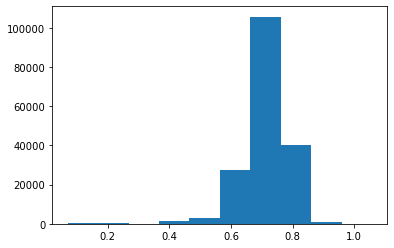

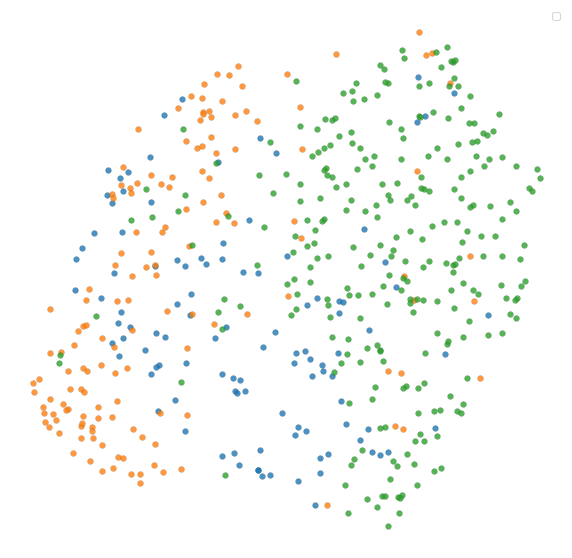

In [7]:
utils.plot_umap(ind_moments, model, mapping)

In [8]:
current_losses = []
for e in range(epoch):
    x, dist, y = model_utils.sample_random_moment_with_close_distant(ind_moments,
                                                                     batch=300,
                                                                     number_of_moments=ind_moments[0].shape[1])

    x, dist, y = model(x, dist, y)
    loss = model_utils.loss_func(x, dist, y)
    optimizer.zero_grad()
    loss.backward()
    current_losses.append(loss.item())
    optimizer.step()
    if e % 1000 == 0:
        print(np.mean(current_losses))
        current_losses = []

0.2034837156534195
0.10624462398514152
0.06977851822227239
0.0675983008556068
0.06583262876048684
0.06441170582547784
0.06247017702460289
0.060581727504730225
0.059341083463281395
0.0582361799813807
0.0570573298484087
0.05609994201362133
0.05592169919610023
0.05508304738625884
0.054679227989166974
0.05470986879989505
0.054453367076814176
0.05419058060273528
0.05397271337360144
0.054063143538311126


No handles with labels found to put in legend.


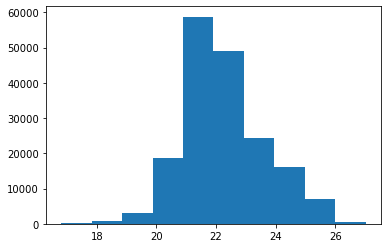

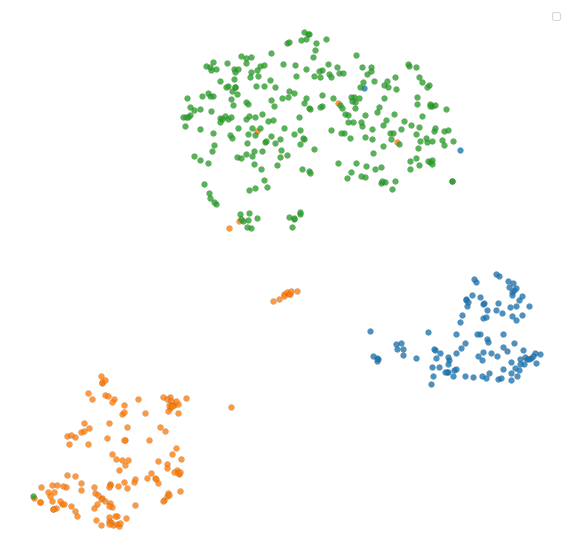

In [9]:
utils.plot_umap(ind_moments, model, mapping)

In [10]:
from caretta import dynamic_time_warping as dtw

In [11]:
def fill_template_kmer_coords(coords, shape=(27, 3)):
    padded_coords = np.zeros(shape)
    padded_coords[:coords.shape[0]] = coords
    return padded_coords

In [12]:
proteins = [model.forward_single(torch.tensor(x.astype("float32"))).cpu().detach().numpy() for x in ind_moments]
residue_coords = [x.coordinates for x in invariants_kmer]

In [13]:
i1 = 3
i2 = -1
protein_a = proteins[i1]
protein_b = proteins[i2]
coords_a = residue_coords[i1]
coords_b = residue_coords[i2]

In [14]:
score_matrix = np.array([[get_caretta_score(x, y, gamma=.1) for y in protein_b] for x in protein_a])

In [15]:
p1_idx, p2_idx, _ = dtw.dtw_align(score_matrix, gap_open_penalty=0., gap_extend_penalty=0.)

In [16]:
def get_tm_score(coords1, coords2, l1, l2):
    rot, trans = superposition_functions.svd_superimpose(coords1, coords2)
    coords2_rotated = np.dot(coords2 - helper.nb_mean_axis_0(coords2), rot)
    coords1_translated = coords1 - helper.nb_mean_axis_0(coords1)
    return tm_score(coords1_translated, coords2_rotated, l1, l2), (coords1_translated, coords2_rotated)

core_p1_idx, core_p2_idx = helper.get_common_positions(p1_idx, p2_idx)
aligned_tm_score, (p1_rotated_common, p2_rotated_common) = get_tm_score(coords_a[core_p1_idx], coords_b[core_p2_idx], coords_a.shape[0], coords_b.shape[0])
unaligned_tm_score, _ = get_tm_score(coords_a[:min(coords_a.shape[0], coords_b.shape[0])], coords_b[:min(coords_a.shape[0], coords_b.shape[0])], coords_a.shape[0], coords_b.shape[0])
aligned_tm_score, unaligned_tm_score

(0.944280822370147, 0.8937973460097405)

In [17]:
def fill_gaps_for_plotting(alignment_idx):
    while np.where(alignment_idx == -1)[0].shape[0] != 0:
        current = np.where(alignment_idx == -1)[0][0]
        if current == 0:
            alignment_idx[current] = alignment_idx[current + 1]
        else:
            alignment_idx[current] = alignment_idx[current - 1]
    return alignment_idx

In [18]:
p1_idx_filled, p2_idx_filled = fill_gaps_for_plotting(p1_idx), fill_gaps_for_plotting(p2_idx)

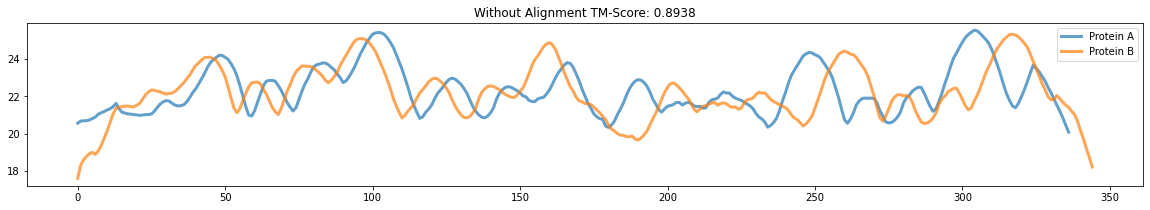

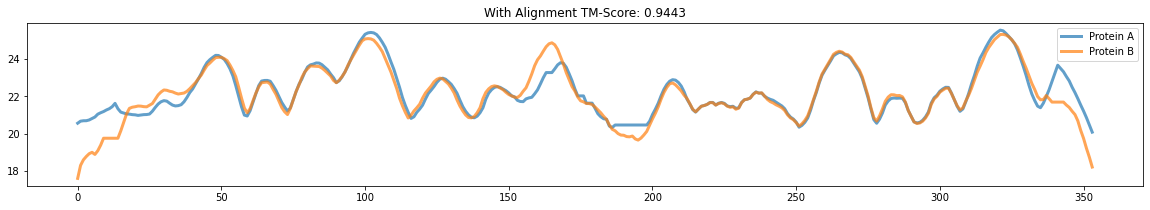

In [19]:
plt.figure(figsize=(20,3))
plt.plot(protein_a, lw=3, alpha=.7)
plt.plot(protein_b, lw=3, alpha=.7)
plt.title(f"Without Alignment TM-Score: {unaligned_tm_score:.4f}")
plt.legend(["Protein A", "Protein B"])
plt.show()
plt.figure(figsize=(20,3))
plt.plot(protein_a[p1_idx_filled], lw=3, alpha=.7)
plt.plot(protein_b[p2_idx_filled], lw=3, alpha=.7)
plt.title(f"With Alignment TM-Score: {aligned_tm_score:.4f}")
plt.legend(["Protein A", "Protein B"])
plt.show()

In [20]:
from subprocess import check_call as ck

In [21]:
# this alignment was computed using TM-align Version 20170708 

tm_align_result_p1 = "ERPTFYRQELNKTIWEVPERYQNLSPVGS--YGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDF--GV-----------------ATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLTQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVA-DPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLD"
tm_align_result_p2 = "------PEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNLNKVRVAIKKIS-PFEHQTYCQRTLREIKILLRFRHENIIGINDIIR-APTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLA-RVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQ-----"
tm_align_result = {0: tm_align_result_p1, 1: tm_align_result_p2}
tm_align_indices = multiple_alignment.alignment_to_numpy(tm_align_result)
tm_p1_idx = tm_align_indices[0]
tm_p2_idx = tm_align_indices[1]

In [22]:
core_p1_idx, core_p2_idx = helper.get_common_positions(tm_p1_idx, tm_p2_idx)
aligned_tm_score, (p1_rotated_common, p2_rotated_common) = get_tm_score(coords_a[core_p1_idx], coords_b[core_p2_idx], coords_a.shape[0], coords_b.shape[0])
unaligned_tm_score, _ = get_tm_score(coords_a[:min(coords_a.shape[0], coords_b.shape[0])], coords_b[:min(coords_a.shape[0], coords_b.shape[0])], coords_a.shape[0], coords_b.shape[0])
f"TM-aligned, TM-score: {aligned_tm_score:4f}"

'TM-aligned, TM-score: 0.945985'